In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import numpy as np

And load the first file:

In [2]:
first_file = '/kaggle/input/steam-games-dataset/games.json'
with open(first_file, 'r') as file:
    json_data = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/steam-games-dataset/games.json'

I'll convert the JSON into a DataFrame, ignoring the variables I'm not interested in:

In [ ]:
unnecessary_vars = [
    'packages', 'screenshots', 'movies', 'score_rank', 'header_image',
    'reviews', 'website', 'support_url', 'notes', 'support_email',
    'recommendations', 'user_score', 'median_playtime_forever',
    'median_playtime_2weeks', 'required_age', 'metacritic_score',
    'metacritic_url', 'peak_ccu'
]

In [ ]:
# Process each game's information and store in a list
games = [{
    **{k: v for k, v in game_info.items() if k not in unnecessary_vars},
    'tags': ', '.join(game_info.get('tags', {}).keys()) if isinstance(game_info.get('tags', {}), dict) else '',
    'app_id': app_id
} for app_id, game_info in json_data.items()]

# Create a DataFrame from the processed list
df = pd.DataFrame(games)

## Data structure

Let's take a look at the first few rows of the DataFrame:

In [ ]:
df

In [ ]:
# Number of rows and columns
df.shape

In [ ]:
# Fields with missing values
def is_empty(cell):
    if isinstance(cell, list):
        return len(cell) == 0
    elif isinstance(cell, str):
        return cell == ''
    else:
        return pd.isna(cell)
print(df.applymap(is_empty).sum())

Some variables contain missing values, mainly because there are games published on Steam as tests that contain little information. In the case of *full_audio_languages*, the field has a missing value if the game does not have spoken dialogue, which is quite common. In the case of *tags*, the *tags* field represents labels chosen by users, so very unpopular games may not have tags. Except for the audio languages, rows with missing values in other fields should be deleted as they are not very relevant for the analysis, as we'll see later.

## Individual variables

Let's have a look at each of the variables in the dataset. **app_id** is the unique identifier of each game on Steam and allows us to check there are no duplicates:

In [ ]:
df['app_id'].duplicated().sum()

In [3]:
# Convert 'release_date' to datetime
df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')

NameError: name 'df' is not defined

In [4]:
# Earliest date
df['release_date'].min()

NameError: name 'df' is not defined

In [5]:
# Latest date
df['release_date'].max()

NameError: name 'df' is not defined

In [6]:
# Unreleased games
df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y', errors='coerce')
df[df['release_date'] > '2023-12-01']

NameError: name 'df' is not defined

There are 3 games with a release date in the future. We'll have to remove them from the dataset.

In [7]:
# Number of games published by month
plt.figure(figsize=(12, 6))
df.groupby(df['release_date'].dt.to_period('M')).size().plot(kind='line')
plt.title('Games published by month')
plt.ylabel('Number of games')
plt.grid(True)
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

We can see that the number of games published per month increases over time, both because more games are being released and because older games are being removed from the store.

In [8]:
# Prices
bins = range(0, 105, 5)
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=bins, edgecolor='black')
plt.title('Distribution of game prices')
plt.xlabel('Price')
plt.ylabel('Number of games')
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

In the distribution of game prices, we can see that the majority of games are either free or have a very low price, with very few games priced above $60.

In [9]:
# Proportion of free games
round(df[df['price'] == 0].shape[0] / df.shape[0], 2)

NameError: name 'df' is not defined

19% of games are free.

In [10]:
# Maximum price
df['price'].max()

NameError: name 'df' is not defined

The maximum price is almost $1000. Let's see the games with the highest prices:

In [11]:
# Games with a price over $100
df[df['price'] > 100]

NameError: name 'df' is not defined

We can see that there are only 112 games with a price exceeding $100.

In [12]:
# Number of DLCs (up to 10)
dlc_counts = df['dlc_count'].value_counts().sort_index()
dlc_counts = dlc_counts[dlc_counts.index <= 10]
plt.figure(figsize=(10, 6))
dlc_counts.plot(kind='bar')
plt.title('Distribution of the number of DLCs')
plt.xlabel('Number of DLCs')
plt.ylabel('Number of games')
plt.show()

NameError: name 'df' is not defined

The *dlc_count* field contains the count of downloadable content (DLC) available for each game. Its distribution between 0 and 10 shows that the majority of games do not have any additional content. If we examine the distribution only for games with 2 or more DLCs, we can see that as the number of DLCs increases, the number of games decreases exponentially. The game with the most additional content has 2366 DLCs.

In [13]:
# Distribution of the number of DLCs (2 to 50)
dlc_counts = df['dlc_count'].value_counts().sort_index()
dlc_counts = dlc_counts[(dlc_counts.index >= 2) & (dlc_counts.index <= 50)]
plt.figure(figsize=(12, 6))
dlc_counts.plot(kind='bar')
plt.title('Distribution of the number of DLCs')
plt.xlabel('Number of DLCs')
plt.ylabel('Number of games')
plt.show()

NameError: name 'df' is not defined

In [14]:
# Maximum number of DLCs
df['dlc_count'].max()

NameError: name 'df' is not defined

Steam has three sections for game descriptions that can be analyzed using word clouds. The first is the short description, the second is "about this game," and the third is the "detailed description." We can see that the most frequent words are similar in all three sections, so I will focus on the short description.

In [15]:
# Wordcloud: short_description
all_descriptions = ','.join(list(df['short_description'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

NameError: name 'df' is not defined

In [16]:
# Wordcloud: about_the_game
all_descriptions = ','.join(list(df['about_the_game'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

NameError: name 'df' is not defined

In [17]:
# Wordcloud: detailed_description
all_descriptions = ','.join(list(df['detailed_description'].values))
wordcloud = WordCloud(width = 1200, height = 600, max_words=50).generate(all_descriptions)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

NameError: name 'df' is not defined

We can also analyze the proportion of games available for different operating systems, such as Windows, Mac, and Linux:

In [18]:
# OS support
platform_sums = df[['windows', 'mac', 'linux']].sum()
plt.figure(figsize=(10, 5))
platform_sums.plot(kind='bar')
plt.title('Number of games available on each platform')
plt.xlabel('OS')
plt.ylabel('Number of games')
plt.show()

NameError: name 'df' is not defined

The variable *Achievements* contains the number of in-game achievements, which are displayed on the player's public profile. 51% of the games do not have any achievements, and the game with the most achievements has 9821:

In [19]:
# Achievements (limited to 150)
plt.figure(figsize=(10, 6))
plt.hist(df['achievements'].dropna(), bins=2000, edgecolor='black')
plt.title('Distribution of achivements')
plt.xlabel('Number of achivements')
plt.ylabel('Number of games')
plt.xlim(0, 150)
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>

In [20]:
# Proportion of games with 0 achievements
count_of_zero_achievements = (df['achievements'] == 0).sum()
total_rows = len(df)
round(count_of_zero_achievements / total_rows, 2)

NameError: name 'df' is not defined

In [21]:
# Maximum number of achievements in a game
df['achievements'].max()

NameError: name 'df' is not defined

We also have information about the language of the game's text and the language of the game's audio. In both cases, English is the dominant language:

In [22]:
# Text languages (top 25)
all_languages = [lang for sublist in df['supported_languages'].dropna() for lang in sublist if sublist]
language_counts = Counter(all_languages)
lang_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count']).sort_values('Count', ascending=False)
top_lang_df = lang_df.head(25)
plt.figure(figsize=(12, 12))
plt.barh(top_lang_df['Language'], top_lang_df['Count'], color='skyblue')
plt.title('Top 25 frequencies of text languages')
plt.ylabel('Language')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

NameError: name 'df' is not defined

In [ ]:
# Audio languages (top 25)
all_languages = [lang for sublist in df['full_audio_languages'].dropna() for lang in sublist if sublist]
language_counts = Counter(all_languages)
lang_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count']).sort_values('Count', ascending=False)
top_lang_df = lang_df.head(25)
plt.figure(figsize=(12, 12))
plt.barh(top_lang_df['Language'], top_lang_df['Count'], color='skyblue')
plt.title('Top 25 frequencies of audio languages')
plt.ylabel('Language')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

We can see that there are very prolific development companies, as the top 10 with the most games have created more than 100 games. We can also look at the companies that have published the most games, as often the company that develops the game is different from the one responsible for distribution.

In [23]:
# Developers (top 10)
all_developers = [dev for sublist in df['developers'].dropna() for dev in sublist if sublist]
developer_counts = Counter(all_developers)
top_developers = pd.DataFrame(developer_counts.most_common(10), columns=['Developer', 'Games Developed'])
plt.figure(figsize=(12, 6))
plt.barh(top_developers['Developer'], top_developers['Games Developed'], color='skyblue')
plt.title('Top 10 developers by number of games developed')
plt.ylabel('Developer')
plt.xlabel('Number of games developed')
plt.xticks(rotation=50)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

NameError: name 'df' is not defined

In [24]:
# Publishers (top 10)
all_publishers = [pub for sublist in df['publishers'] for pub in sublist if sublist and pub != '']
publisher_counts = Counter(all_publishers)
top_publishers = pd.DataFrame(publisher_counts.most_common(10), columns=['Publisher', 'Games Published'])
plt.figure(figsize=(12, 6))
plt.barh(top_publishers['Publisher'], top_publishers['Games Published'], color='skyblue')
plt.title('Top 10 publishers by number of games published')
plt.ylabel('Publisher')
plt.xlabel('Number of games published')
plt.xticks(rotation=50)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

NameError: name 'df' is not defined

In [25]:
# Total number of developers
all_developers = [dev for sublist in df['developers'].dropna() for dev in sublist]
len(set(all_developers))

NameError: name 'df' is not defined

In [26]:
# Total number of publishers
all_publishers = [dev for sublist in df['publishers'].dropna() for dev in sublist]
len(set(all_publishers))

NameError: name 'df' is not defined

The variable *categories* contains information about the number of players or features of the game.

In [27]:
# Categories (top 20)
all_categories = [category for sublist in df['categories'].dropna() for category in sublist if sublist]
category_counts = Counter(all_categories)
top_categories = pd.DataFrame(category_counts.most_common(20), columns=['Category', 'Games'])
plt.figure(figsize=(12, 12))
plt.barh(top_categories['Category'], top_categories['Games'], color='skyblue')
plt.title('Top 20 categories by number of games')
plt.ylabel('Category')
plt.xlabel('Number of games')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

NameError: name 'df' is not defined

*Genres* contains the game's genres, selected by the distributor, while *tags* contains tags that describe the game, chosen by Steam users:

In [28]:
# Genres (top 10)
all_genres = [genre for sublist in df['genres'].dropna() for genre in sublist if sublist]
genre_counts = Counter(all_genres)
top_genres = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Number of Games'])
plt.figure(figsize=(12, 6))
plt.barh(top_genres['Genre'], top_genres['Number of Games'], color='skyblue')
plt.title('Top 10 genres by number of games')
plt.ylabel('Genre')
plt.xlabel('Number of games')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.show()

NameError: name 'df' is not defined

In [29]:
# Tags (top 10)
all_tags = [tag.strip() for sublist in df['tags'].dropna() for tag in sublist.split(',') if sublist]
tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(tag_counts.most_common(10), columns=['Tag', 'Number of Games'])
plt.figure(figsize=(12, 6))
plt.barh(top_tags['Tag'], top_tags['Number of Games'], color='skyblue')
plt.title('Top 10 tags by number of games')
plt.ylabel('Tag')
plt.xlabel('Number of games')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.show()

NameError: name 'df' is not defined

The variables *positive* and *negative* represent the number of positive and negative reviews for each game, which can be visualized together. We can see that there are extreme values that are not errors but are due to being the most popular games on the platform. Additionally, 24% of the games have no reviews:

In [30]:
# Reviews
plt.figure(figsize=(12, 6))
plt.scatter(df['positive'], df['negative'], alpha=0.5)
plt.title('Number of positive vs. negative reviews')
plt.xlabel('Positive reviews')
plt.ylabel('Negative reviews')
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# More than 500000 negative reviews
df[df['negative'] > 500000]

In [31]:
# Proportion of games with no reviews
round(df[(df['positive'] + df['negative']) == 0].shape[0] / df.shape[0], 2)

NameError: name 'df' is not defined

The variable *estimated_owners* contains an estimation of game sales, categorized by ranges. Most games fall into the first category, with sales between 0 and 20,000 units. I will remove games with 0 reviews from the dataset, since these are not relevant for the analysis:

In [32]:
# Estimated units sold
df['estimated_owners'].value_counts().plot(kind='bar')

NameError: name 'df' is not defined

In [33]:
# Games with 0 owners
df[df['estimated_owners'] == '0 - 0']

NameError: name 'df' is not defined

We also have information about the average time players have spent on a game, both the total time and the time spent in the last 2 weeks, measured in minutes. We can see that 82% of games have a total playtime of 0 minutes, indicating missing data. If we ignore these rows, the distribution changes. We can observe that games with data on playtime are the most popular since they have 90 times more comments:

NameError: name 'df' is not defined

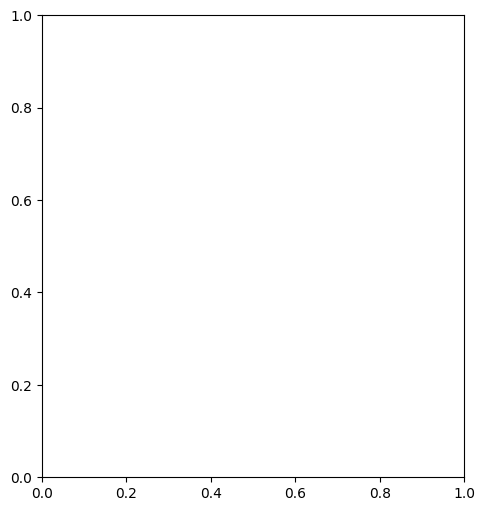

In [34]:
# Average playtime
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['average_playtime_forever'], bins=15000, color='blue', alpha=0.7)
plt.title('Total playtime')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Number of games')
plt.xlim(0, 100)
plt.subplot(1, 2, 2)
plt.hist(df['average_playtime_2weeks'], bins=32000, color='green', alpha=0.7)
plt.title('Playtime in the last 2 weeks')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Number of games')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

In [ ]:
# Proportion of games without playtime data
proportion = df[df['average_playtime_forever'] == 0].shape[0] / df.shape[0]
round(proportion, 2)

In [ ]:
# Average playtime (excluding 0)
filtered_df = df[df['average_playtime_forever'] != 0]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(filtered_df['average_playtime_forever'], bins=15000, color='blue', alpha=0.7)
plt.title('Minutes played (total)')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Number of games')
plt.xlim(0, 100)
plt.subplot(1, 2, 2)
plt.hist(df['average_playtime_2weeks'], bins=32000, color='green', alpha=0.7)
plt.title('Minutes played (last 2 weeks)')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Number of games')
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

In [ ]:
# Number of comments when playtime == 0 vs. > 0
group_1 = df[df['average_playtime_forever'] == 0]
group_1_mean = (group_1['positive'] + group_1['negative']).mean()
group_2 = df[df['average_playtime_forever'] > 0]
group_2_mean = (group_2['positive'] + group_2['negative']).mean()
print(f"Number of reviews (playtime_forever == 0): {group_1_mean}")
print(f"Number of reviews (playtime_forever > 0): {group_2_mean}")

## Bivariate analysis

Let's see some variables that are interesting for visualization as they vary according to the genre. The price, which we can see doubles between the "Massive multiplayer" and "Sports" genres:

In [ ]:
# Price by genre
exploded_df = df.explode('genres')
average_price_by_genre = exploded_df.groupby('genres')['price'].mean().sort_values()
plt.figure(figsize=(12, 12))
average_price_by_genre.plot(kind='barh', color='skyblue')
plt.title('Average price by genre')
plt.xlabel('Average price')
plt.ylabel('Genre')
plt.show()

The number of downloadable contents (DLCs) also varies greatly between genres:

In [ ]:
# DLCs per Genre
exploded_df = df.explode('genres')
average_dlc_count_by_genre = exploded_df.groupby('genres')['dlc_count'].mean().sort_values()
plt.figure(figsize=(12, 12))
average_dlc_count_by_genre.plot(kind='barh', color='skyblue')
plt.title('Average DLCs per genre')
plt.xlabel('DLCs')
plt.ylabel('Genre')
plt.show()

The description, which contains different terms for the sports genre compared to the RPG genre:

In [ ]:
# Wordcloud by genres: Sports i RPG
exploded_df = df.explode('genres')
sports_df = exploded_df[exploded_df['genres'] == 'Sports']
rpg_df = exploded_df[exploded_df['genres'] == 'RPG']
sports_text = ' '.join(sports_df['short_description'].dropna())
rpg_text = ' '.join(rpg_df['short_description'].dropna())
def generate_wordcloud(text, title, additional_stopwords=None):
    stopwords = set(STOPWORDS)
    if additional_stopwords:
        stopwords = stopwords.union(additional_stopwords)
    wordcloud = WordCloud(width=1200, height=600, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
generate_wordcloud(sports_text, 'Sports', additional_stopwords={'game'})
generate_wordcloud(rpg_text, 'RPG', additional_stopwords={'game'})

And the playtime in the last two weeks:

In [ ]:
# Playtime by Genre
filtered_df = df[df['average_playtime_forever'] != 0]
df_expanded = filtered_df.explode('genres')
mean_playtimes = df_expanded.groupby('genres')['average_playtime_2weeks'].mean()
mean_playtimes_sorted = mean_playtimes.sort_values(ascending=False)
mean_playtimes_sorted.plot(kind='barh', figsize=(12, 12))
plt.title('Average playtime in the last two weeks by genre')
plt.ylabel('Genre')
plt.xlabel('Average playtime in the last two weeks (minutes)')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()

## Game length

I will also incorporate information about the game duration from users of the website "How Long to Beat," which, as we can see, varies significantly depending on the genre:

In [35]:
second_file = '/kaggle/input/games-on-steam/steamdb.json'
df3 = pd.read_json(second_file)

FileNotFoundError: File /kaggle/input/games-on-steam/steamdb.json does not exist

In [ ]:
# Game duration by genre (HLTB)
filtered_df = df3[df3['hltb_single'].notna()].copy()
filtered_df['genres'] = filtered_df['genres'].str.split(',')
df_expanded = filtered_df.explode('genres')
average_times = df_expanded.groupby('genres')['hltb_single'].mean()
average_times_sorted = average_times.sort_values(ascending=False)
average_times_sorted.plot(kind='barh', figsize=(12, 8))
plt.title('Game length by genre from "How Long to Beat"')
plt.ylabel('Genre')
plt.xlabel('Duration (hours)')
plt.gca().invert_yaxis()
plt.yticks(fontsize=16)
plt.show()